# Assessment

You are given a dataset to predict cognitive test scores of preschoolers given characteristics of their mothers.

Data dictionary:

* i - mother's IQ
* a - mother's age at child's birth
* h - indicator showing whether mother completed high school (1=True, 0=False)
* w = 1: mother did not work in first three years of child’s life
* w = 2: mother worked in second or third year of child’s life
* w = 3: mother worked part-time in first year of child’s life
* w = 4: mother worked full-time in first year of child’s life
* score - child's IQ (regressand)

**Tasks:**
1. Prepare the data, rename variables as you see fit and justify. Propose the types of data for each variable (python data types).
2. Transform the data so it's easy to analyze - describe what you did and why
3. Perform the exploratory data analysis
4. Perform a linear regression where the regressand is child's IQ
    1. using a single predictor
    2. using multiple predictors
    3. using multiple predictors with an interaction term
    
    For each case, explain your model, model assumptions and how to interpret the regression coefficients.
    
For each task please provide suitable markdown comments and visualizations supporting your work including model diagnostics and evaluation.

You may use any openly available software you need. Present you work in a form of a Jupyter notebook with comments in the markdown cells.
Please upload your ready work to your public github repository and share the link to it with the HR representative.

---


# Preparing the dataset

In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

We import the dataset and read it line by line.

In [2]:
dic = defaultdict(lambda:[])
with open('data.txt', encoding = 'iso-8859-1') as f:
    for i, line in enumerate(f):
        col, val = line.split('|')[1:]
        if i==0 or col=='\x80\x86á\x80\x84\x80º':
            continue
        else:
            dic[col].append(val[:-1])

df = pd.DataFrame(dic)
df.head()

,score,h,i,w,a
0,65,1,'121.117528602603',4,27
1,98,1,'89.3618817100663',4,25
2,85,1,'115.443164881725',4,27
3,83,1,'99.4496394360723',3,25
4,115,1,'92.7457099982118',4,27


All columns are still in string format. We will convert them to integers (for categorical variables) and floats (continuous variables). We will also rename them with more explicit names. 

In [3]:
df[['h', 'w', 'a']] = df[['h', 'w', 'a']].astype(int)
df['i'] = df['i'].map(lambda x:float(x[1:-1]))
df['score'] = df['score'].map(lambda x:float(x))
df = df.rename(columns = {'score': 'child_iq', 'h':'mother_highschool', 'i':'mother_iq', 'w':'mother_work', 'a':'mother_age_birth'})
print(df.dtypes)
df.head()

child_iq             float64
mother_highschool      int32
mother_iq            float64
mother_work            int32
mother_age_birth       int32
dtype: object


,child_iq,mother_highschool,mother_iq,mother_work,mother_age_birth
0,65.0,1,121.117529,4,27
1,98.0,1,89.361882,4,25
2,85.0,1,115.443165,4,27
3,83.0,1,99.449639,3,25
4,115.0,1,92.745710,4,27


We will then convert the mother_work column that can take 4 values (1, 2, 3 ,4) to 4 one-hot encoded features.

In [4]:
for i in range(1, 5): #for the multi-regressor regression, we will ignore values mother_work==1 to avoid multicolinearity during linear regressions
    df[f'mother_work_{i}'] = df['mother_work'].map(lambda x: int(x==i))
df.head()

,child_iq,mother_highschool,mother_iq,mother_work,mother_age_birth,mother_work_1,mother_work_2,mother_work_3,mother_work_4
0,65.0,1,121.117529,4,27,0,0,0,1
1,98.0,1,89.361882,4,25,0,0,0,1
2,85.0,1,115.443165,4,27,0,0,0,1
3,83.0,1,99.449639,3,25,0,0,1,0
4,115.0,1,92.745710,4,27,0,0,0,1


We have for now 9 variables:

* child_iq - child's IQ (regressand)
* mother_higschool - indicator showing whether mother completed high school (1=True, 0=False)
* mother_iq- mother's IQ
* mother_age - mother's age at child's birth
* mother_work_1 = mother did not work in first three years of child’s life (1=True, 0=False)
* mother_work_2 = mother worked in second or third year of child’s life (1=True, 0=False)
* mother_work_3 = mother worked part-time in first year of child’s life (1=True, 0=False)
* mother_work_4 = mother worked full-time in first year of child’s life (1=True, 0=False)
* mother_work = 1 * mother_work_1 + ... + 4 * mother_work_4


**We will drop mother_work and mother_work_1 later**; these would create a multicolinearity issue once we get to the multi-predictors linear regression. We will keep them for now as we are just performing exploratory data analysis.

# Exploratory Data Analysis

## IQ distribution

First of all, it can be interesting to observe the children IQ distribution:

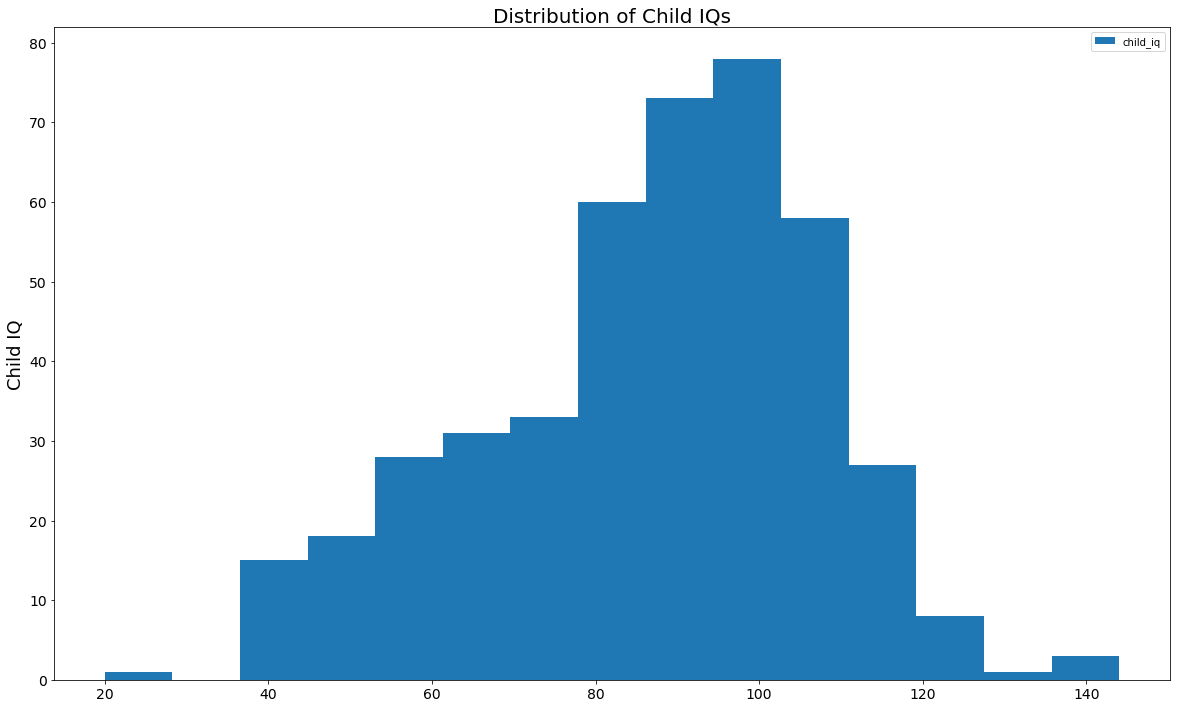

In [5]:
df.plot(kind = 'hist', y='child_iq', figsize=(20, 12), bins = 15, fontsize=14)
plt.ylabel("Child IQ", fontdict={'fontsize':18})
plt.xlabel('')
plt.title("Distribution of Child IQs", fontdict={'fontsize':20})
plt.show()

As we would expect, the distribution looks approximately normal, even though it is slightly skewed to the left.

## Relationship between Mother's IQ and Child's IQ

First, we can explore the correlation between mother's IQ and child's IQ through a scatter plot. The red line below corresponds to the regression line between these two variables.

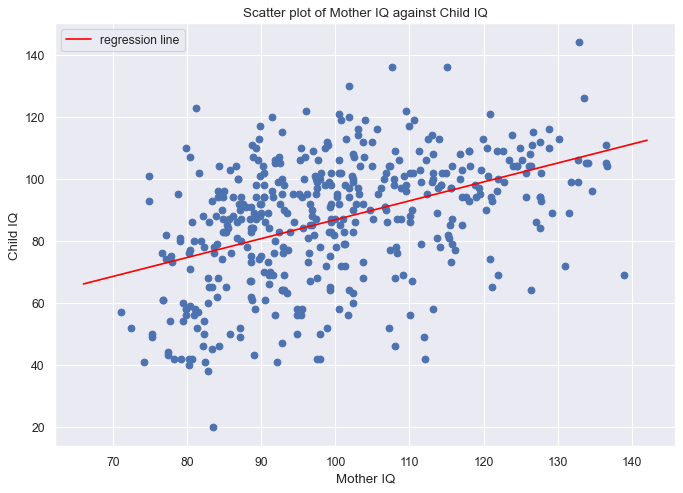

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

plt.figure(figsize = (10,7), dpi = 80)
x = df['mother_iq']
y = df['child_iq']
plt.scatter(x, y)
plt.xlabel('Mother IQ')
plt.ylabel('Child IQ')

#Regression line
a, b = np.polyfit(x, y, 1) #runs the linear regression
z = np.arange(min(x)-5, max(x)+5, 2)
plt.plot(z, a*z + b, color='red', label = 'regression line')

plt.legend()
plt.title('Scatter plot of Mother IQ against Child IQ')
plt.show()

It seems that indeed, a mother's IQ is closely related to her child's IQ. It seems that it will be an important asset in our regressions later on.

## Impact of age at birth and child's IQ

There are only 13 different birth ages in the dataset.

In [7]:
df['mother_age_birth'].nunique()

13

We can then consider mother's age as a categorical variable and plot the relationship between mother's age and average Child IQ at this age.

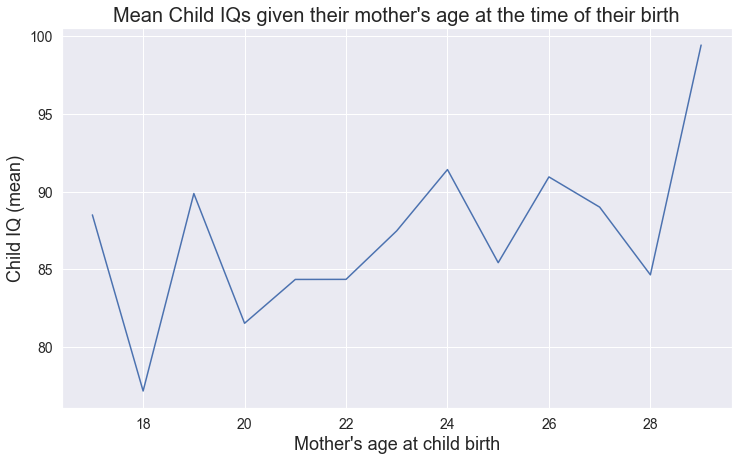

In [8]:
df.groupby('mother_age_birth')['child_iq'].agg(np.mean).plot(y = "mean", legend = False, title = "Time spent for each type of task on average ", figsize=(12, 7), fontsize= 14)
plt.xlabel("Mother's age at child birth", fontdict={'fontsize':18})
plt.ylabel("Child IQ (mean)", fontdict={'fontsize':18})
plt.title("Mean Child IQs given their mother's age at the time of their birth", fontdict={'fontsize':20})
plt.show()

It seems that there is a positive relationship between these two variables: children born later are more likely to have higher IQs.

## Highschool and Child IQ

Below, a bar chart comparing IQ of children with mothers having done highschool or not.

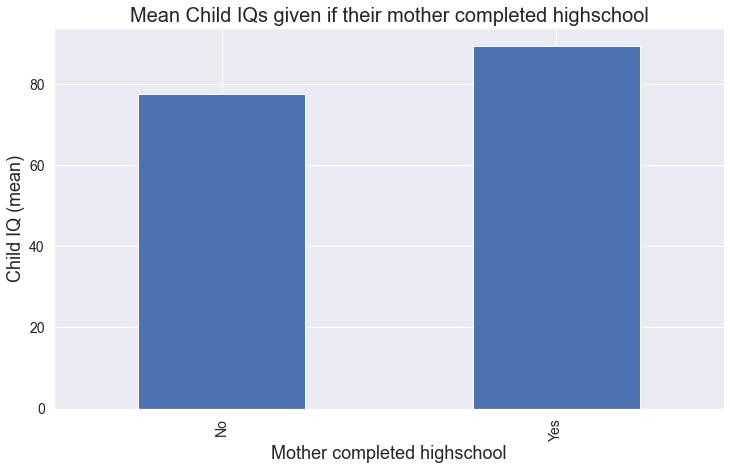

In [9]:
df.groupby('mother_highschool')['child_iq'].agg(np.mean).plot(kind = "bar", y = "mean", legend = False, title = "Time spent for each type of task on average ", figsize=(12, 7), fontsize= 14)
plt.xlabel("Mother completed highschool", fontdict={'fontsize':18})
plt.ylabel("Child IQ (mean)", fontdict={'fontsize':18})
plt.xticks([0, 1], ['No', 'Yes'])
plt.title("Mean Child IQs given if their mother completed highschool", fontdict={'fontsize':20})
plt.show()

It seems that when the mother has completed highschool, child's IQ is more likely to be higher.

## Work and Child's IQ

Below, a boxplot showcasing the distributions of children's IQ given if their mother did not work after their birth, if they only worked during the first year (part-time or full-time) or if they worked during the 2nd and 3rd years after birth.

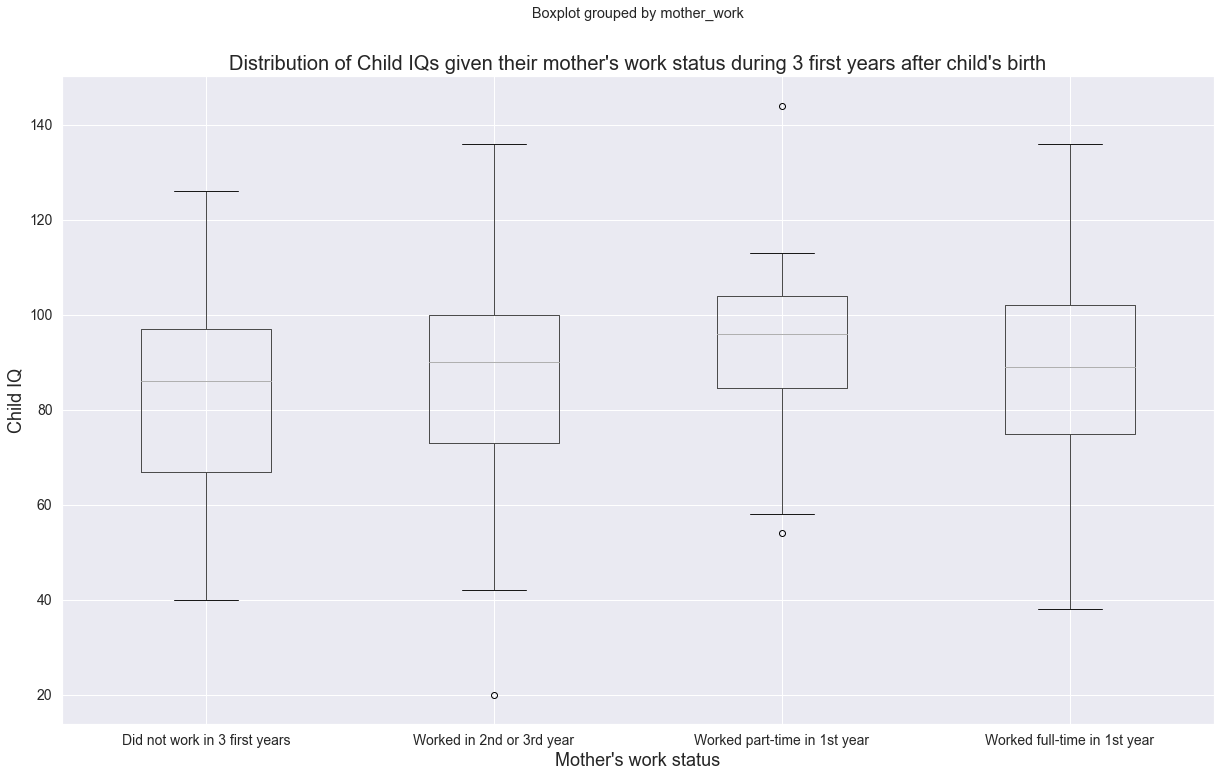

In [10]:
df.boxplot(column='child_iq', by='mother_work', figsize=(20, 12), fontsize=14)
plt.xticks([1, 2, 3, 4], ['Did not work in 3 first years', 'Worked in 2nd or 3rd year', 'Worked part-time in 1st year', 'Worked full-time in 1st year'])
plt.xlabel("Mother's work status", fontdict={'fontsize':18})
plt.ylabel("Child IQ", fontdict={'fontsize':18})
plt.title("Distribution of Child IQs given their mother's work status during 3 first years after child's birth", fontdict={'fontsize':20})
plt.show()

The distribution looks about the same for each working status except for the 'Worked part-time in 1st year' (mother_worked_3) that seems narrower than the other ones. We can also take a look at the counts for each of these statuses:

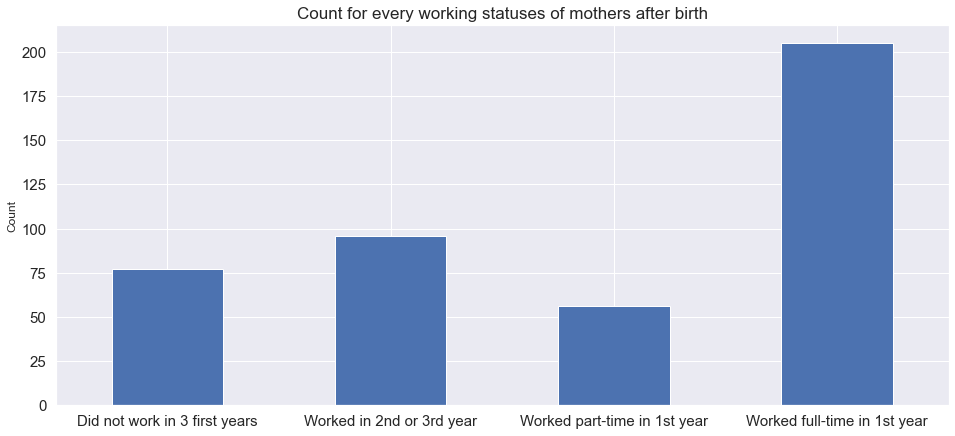

In [11]:
df['mother_work'].astype(str).value_counts().loc[['1', '2', '3', '4']].plot.bar(figsize=(16,7), fontsize = 15)
plt.xticks([0, 1, 2, 3], ['Did not work in 3 first years', 'Worked in 2nd or 3rd year', 'Worked part-time in 1st year', 'Worked full-time in 1st year'], rotation = 'horizontal')
plt.ylabel('Count')
plt.title("Count for every working statuses of mothers after birth", fontdict={'fontsize':17})
plt.show()

## Multicolinearity

We can verify colinearity between our predictors below. This is important when it comes to multilinear regression, as the non-perfect multicolinearity of our predictors is an important assumption.

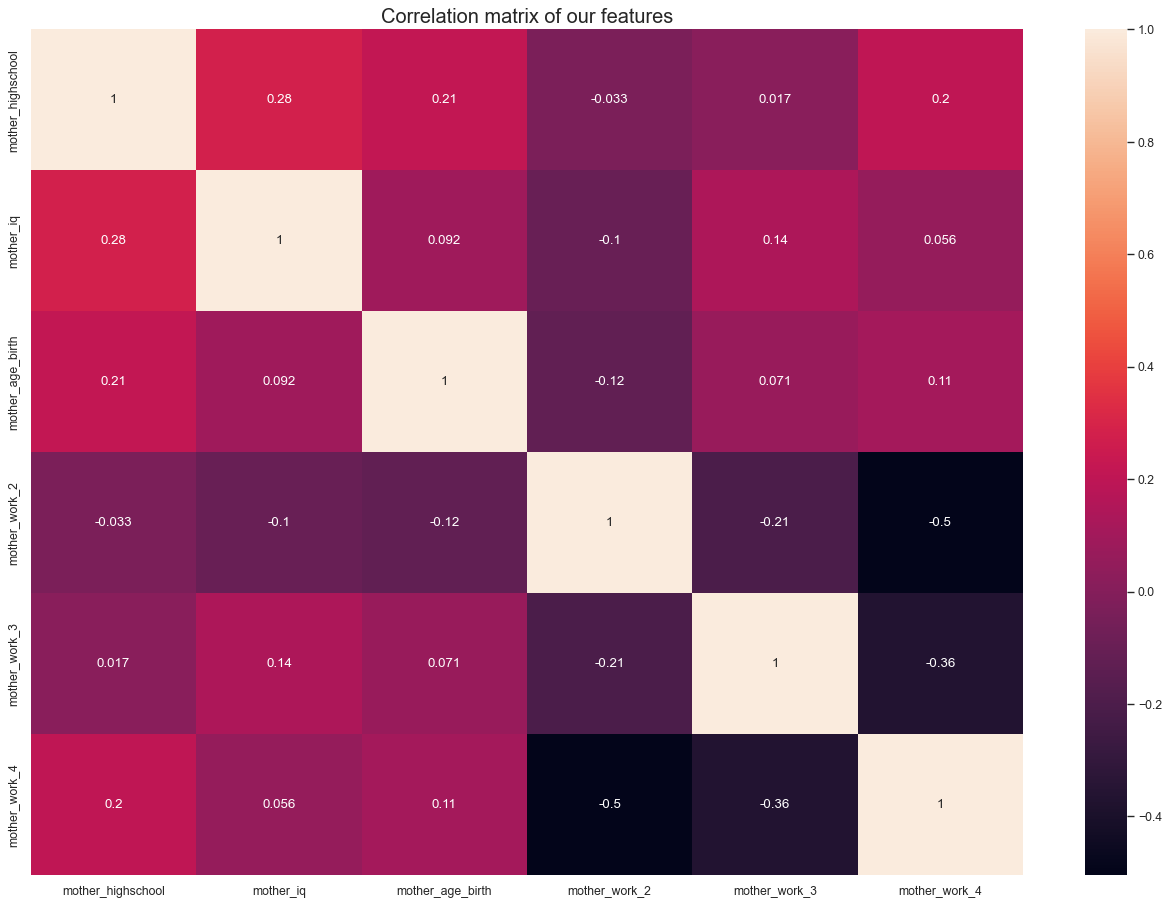

In [12]:
corr_mat = df.drop(['child_iq', 'mother_work', 'mother_work_1'], axis =1).corr() #we ignore mother_work and mother_work_1 that will not be part of our multilinear regression
plt.figure(figsize=(20,14), dpi=80)
sns.heatmap(corr_mat, annot=True)
plt.title("Correlation matrix of our features", fontdict={'fontsize':18})
plt.show()

No colinearity stands out, except for the mother_work variables that have mild colinearity between themselves. Nonetheless, nothing seems too critical.

---

**EDA conclusions:**: From our exploratory analysis, it seems that the most interesting variables for our regressions will be mother_iq, mother_highschool, mother_age_birth and mother_work_3 ('Mother worked part-time during 1st year', which has a distribution slightly different than the rest).

---

We will now run our linear regressions.

# Linear regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

We drop the column mother_work, now irrelevant.

In [14]:
df = df.drop(columns=['mother_work'])

## With a single predictor

Let's represent every single-predictor regression next to each other. For all of these regressions, we assume homoscedasticity, normality and independence of the residuals and linear relationship between the predictor and target variable.

In [15]:
df.columns

Index(['child_iq', 'mother_highschool', 'mother_iq', 'mother_age_birth',
       'mother_work_1', 'mother_work_2', 'mother_work_3', 'mother_work_4'],
      dtype='object')

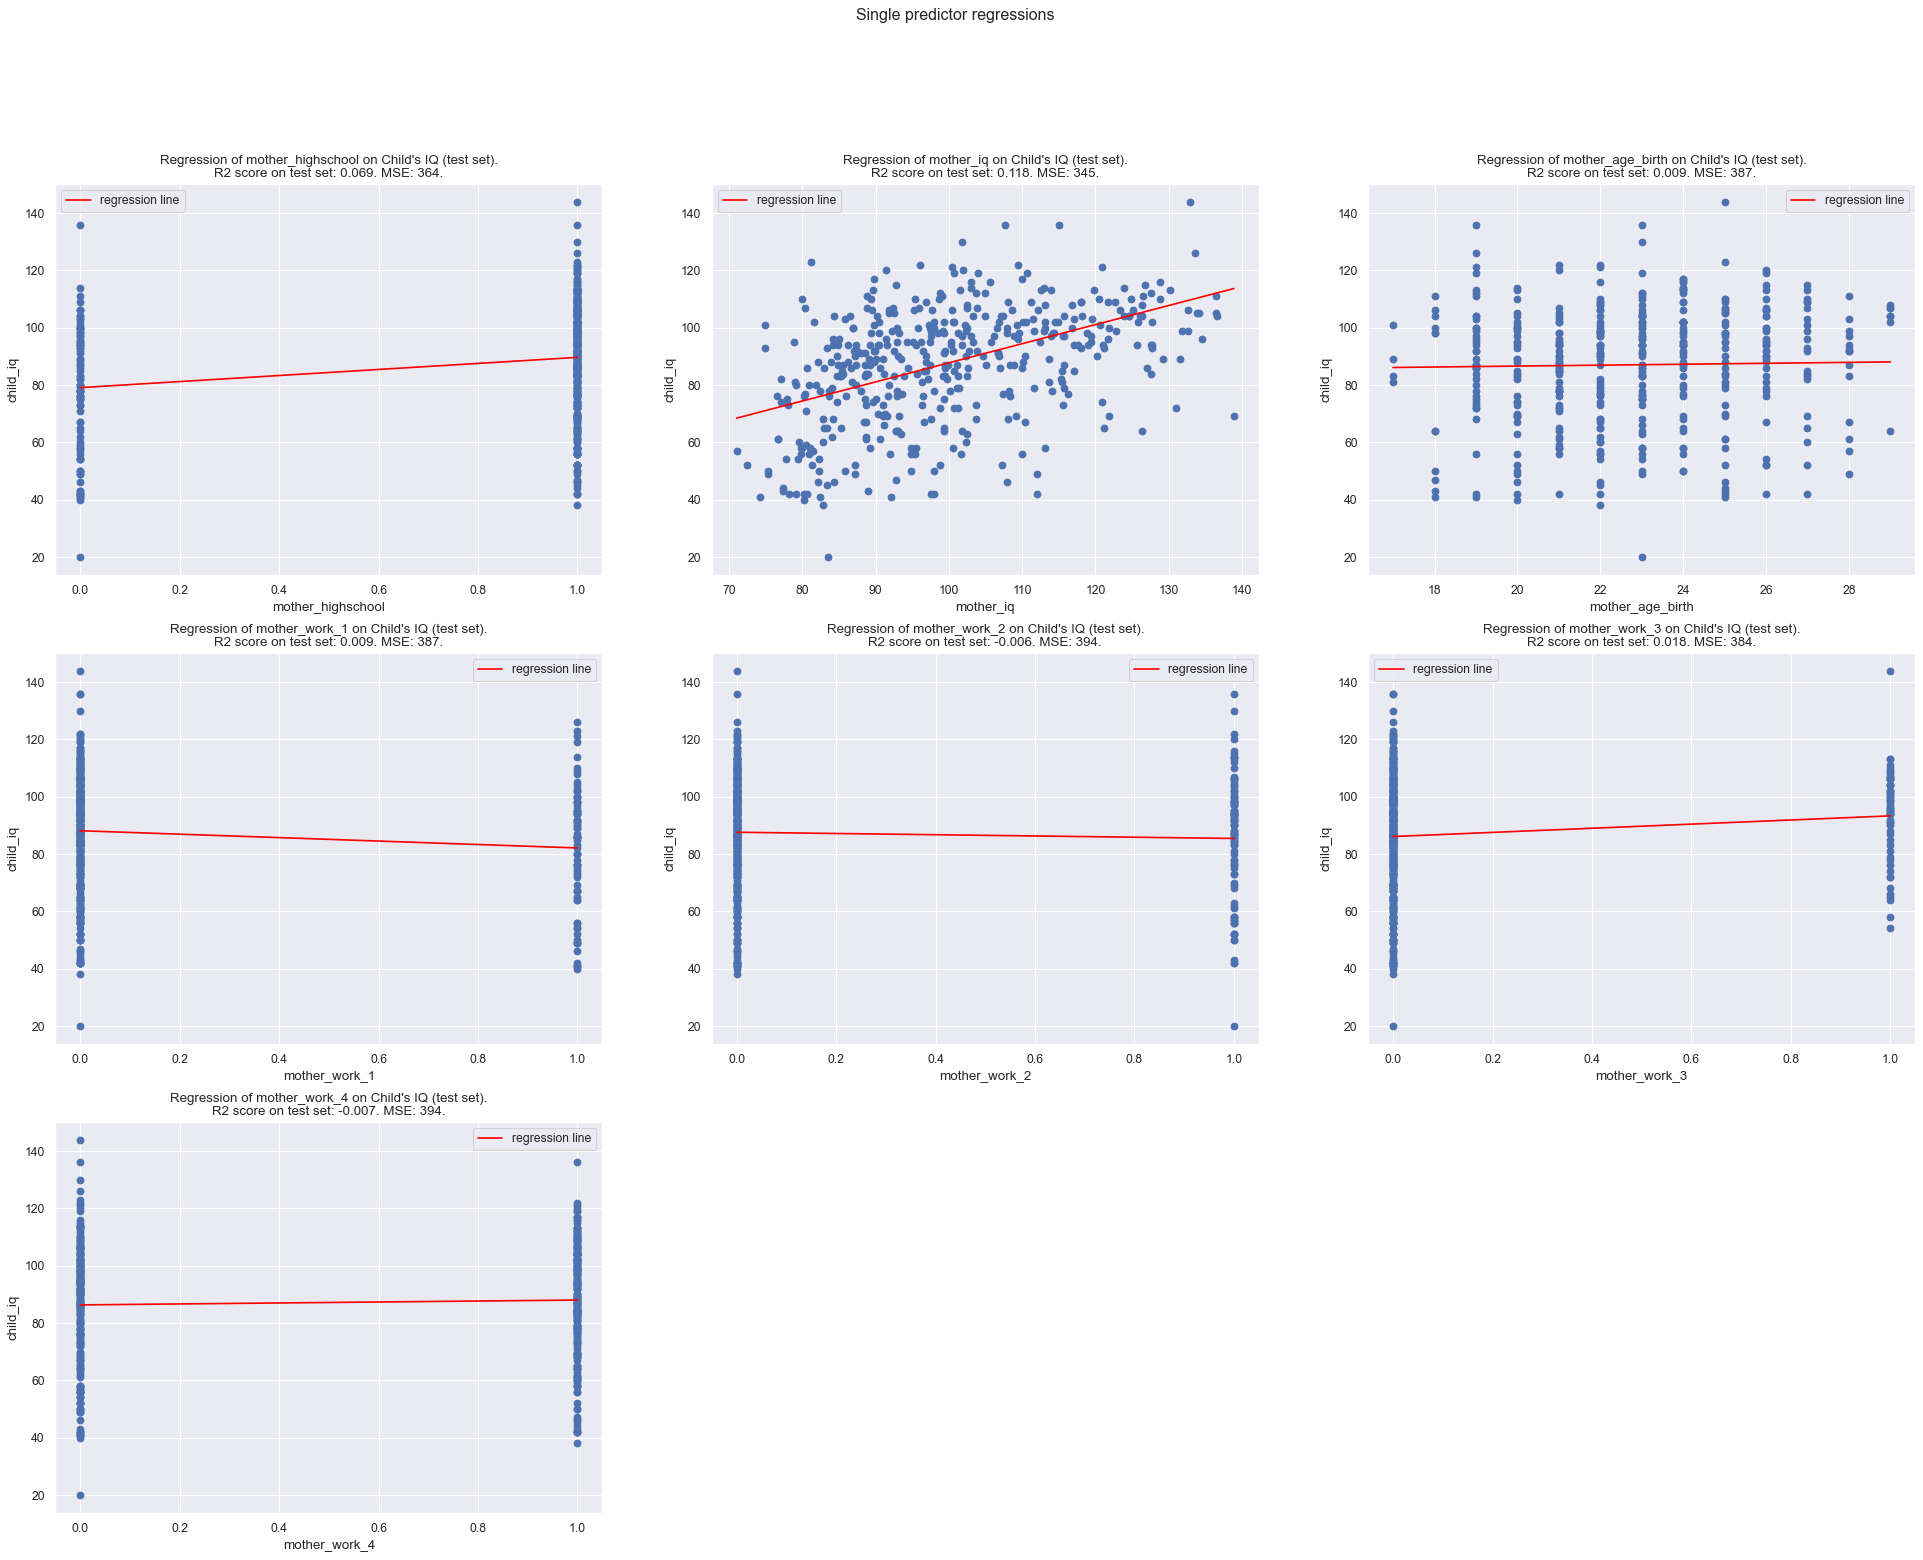

In [16]:
features = ['mother_highschool', 'mother_iq', 'mother_age_birth',
       'mother_work_1', 'mother_work_2', 'mother_work_3', 'mother_work_4']


plt.figure(figsize=(30,22), dpi=80)
res = {}

for i, feat in enumerate(features):
       # 1. Split the dataset into training (70%) and test (30%) sets; no need for a validation set since we do not have hyperparameters to tune.
       X_train, X_test, y_train, y_test = train_test_split(df[[feat]], df['child_iq'], test_size=0.3, random_state=0)

       # 2. Create and fit the model
       model = linear_model.LinearRegression()
       model.fit(X_train, y_train)
       a = model.coef_[0]
       b = model.intercept_

       r2 = model.score(X_test, y_test)
       mse = mean_squared_error(model.predict(X_test), y_test)

       plt.subplot(3, 3, i+1)
       plt.scatter(df[feat], df['child_iq'])

       x_min, x_max = (min(df[feat]), max(df[feat]))
       
       f = lambda x: a*x + b
       res[feat] = y_test - model.predict(X_test)
       
       plt.plot([x_min, x_max], [f(x_min), f(x_max)], c='red', label = f'regression line')
       plt.xlabel(feat)
       plt.ylabel('child_iq')
       plt.legend()
       plt.title(f"Regression of {feat} on Child's IQ (test set).\nR2 score on test set: {round(r2,3)}. MSE: {round(mse)}.")
plt.suptitle('Single predictor regressions')
plt.show()

Best R2 and MSE we get is for mother_iq (R2 = 0.118, MSE = 345). For benchmarking on later models, we also compute the MSE of this single predictor model on the *whole* dataset below.



In [17]:
#Our best single predictor model

model = linear_model.LinearRegression()
model.fit(np.array(df['mother_iq']).reshape(-1,1), df['child_iq'])
mse = mean_squared_error(model.predict(np.array(df['mother_iq']).reshape(-1,1)), df['child_iq'])
r2 = model.score(np.array(df['mother_iq']).reshape(-1,1), df['child_iq'])
print(f'R2 score of best single predictor model on whole dataset: {round(r2,4)}. MSE: {round(mse)}.')

R2 score of best single predictor model on whole dataset: 0.201. MSE: 332.


To have a bit more information on the different regressions, we can also take a look at the shape of the residuals (on the whole dataset).

<Figure size 1600x1280 with 0 Axes>

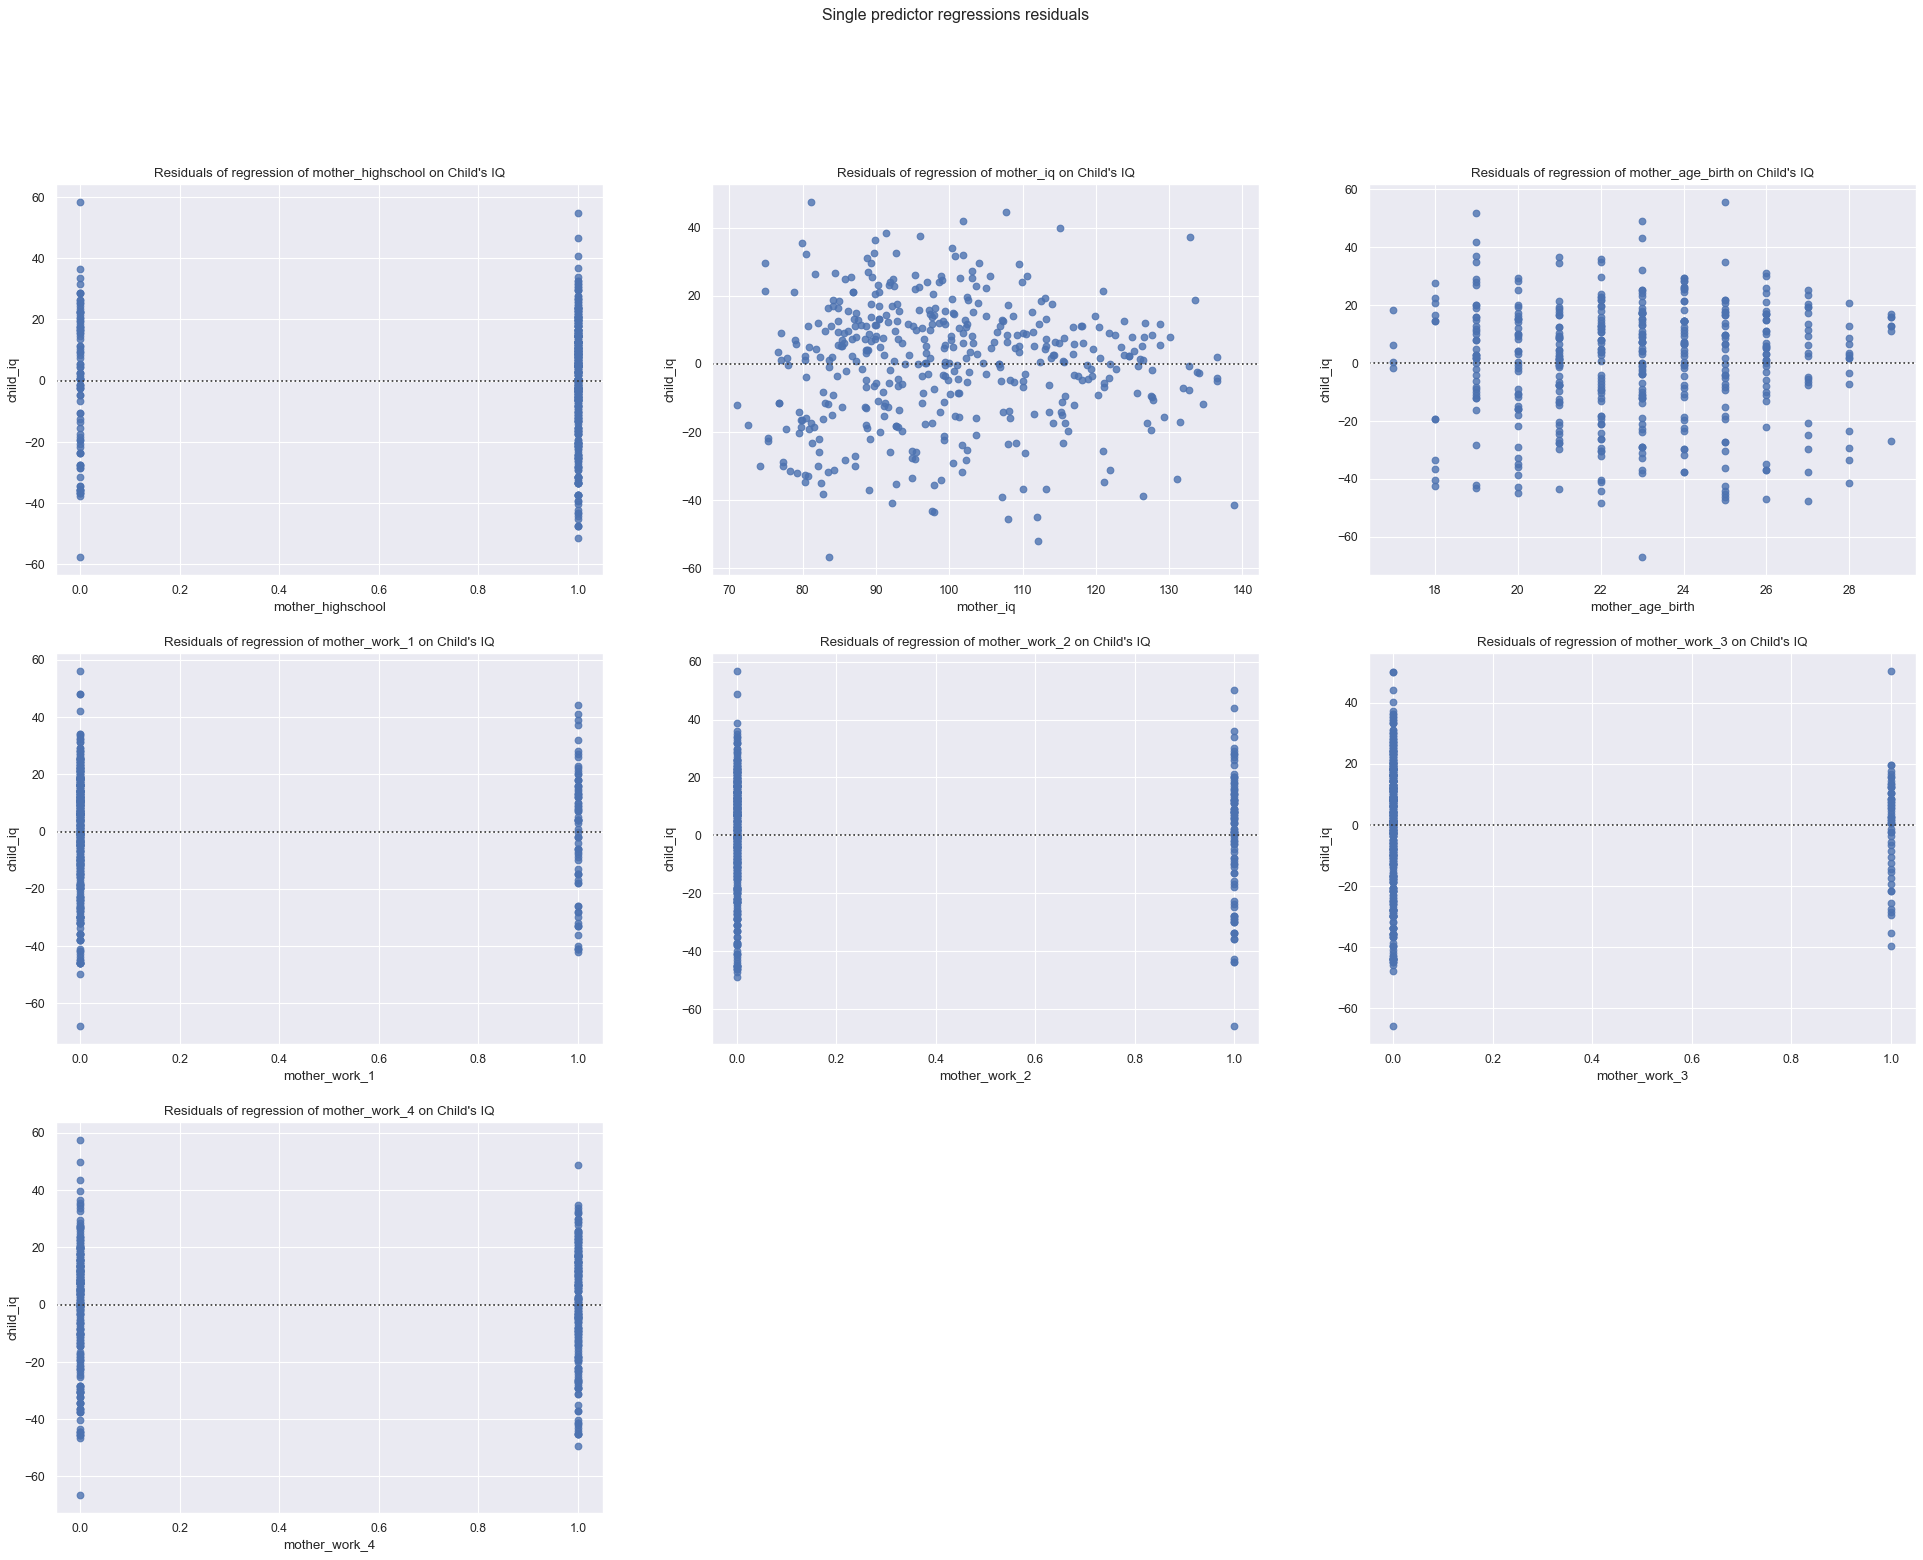

In [18]:
plt.figure(figsize=(20,16), dpi=80)
plt.figure(figsize=(30,22), dpi=80)
for i, feat in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.residplot(x=feat, y='child_iq', data=df)
    plt.xlabel(feat)
    plt.ylabel('child_iq')
    plt.title(f"Residuals of regression of {feat} on Child's IQ")
plt.suptitle('Single predictor regressions residuals')
plt.show()

For binary predictors, it is hard to tell, but it seems that the homoscedasticity is not verified for and mother_work variables, but is verified for the mother_iq and mother_age_birth regressors.

We can also check normality of the residuals.

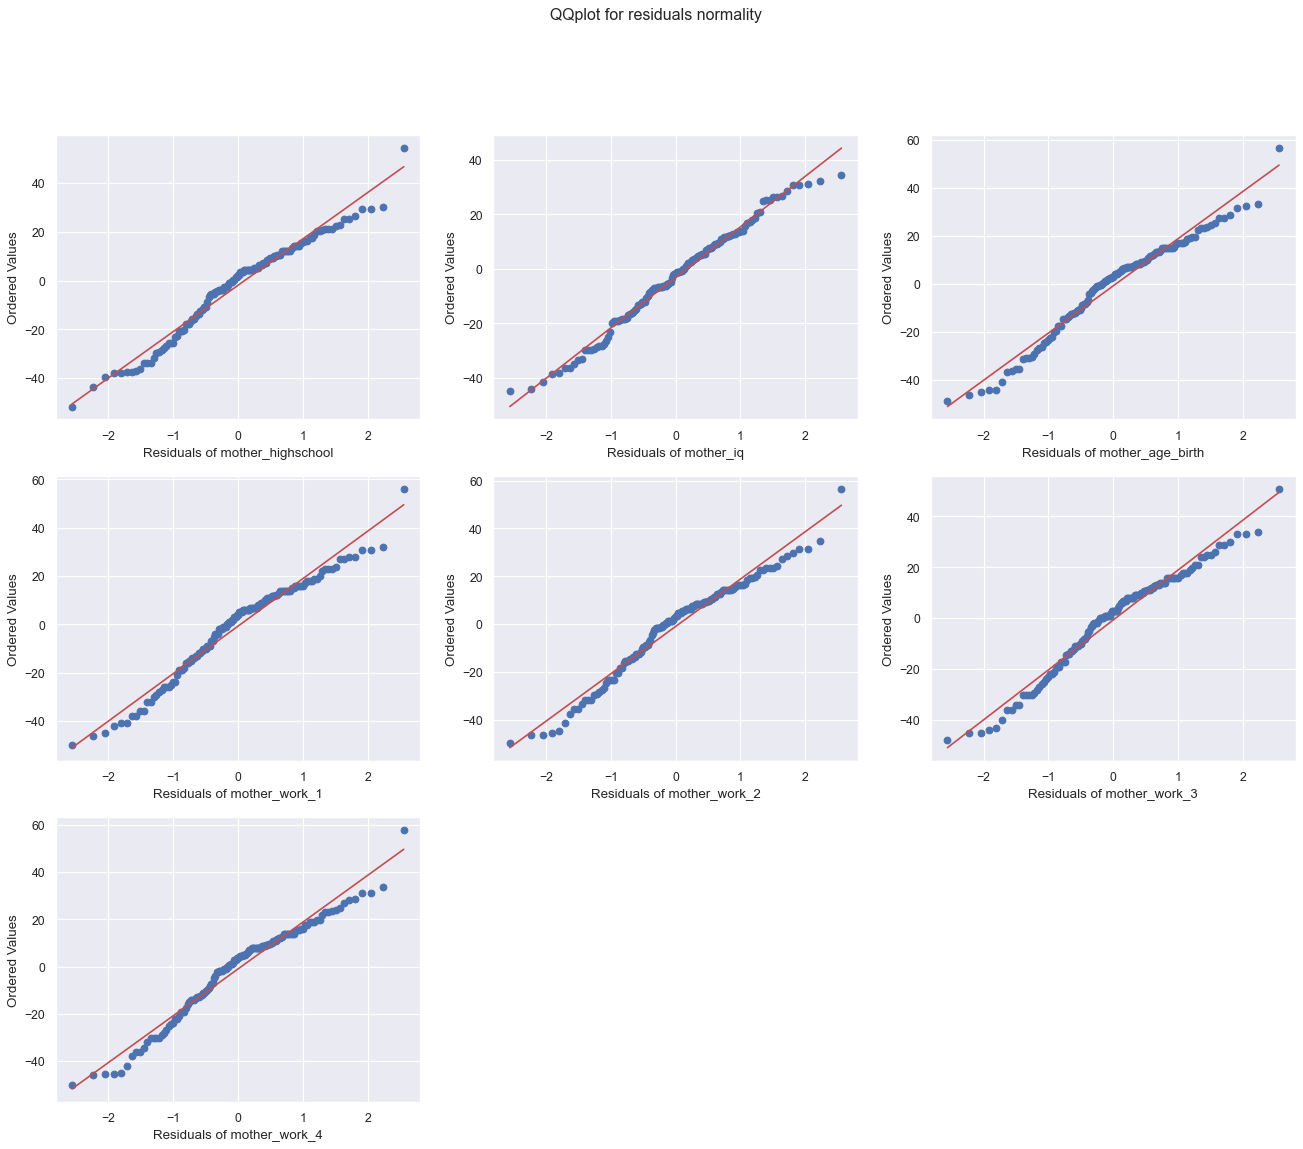

In [19]:
from scipy import stats

plt.figure(figsize=(20,16), dpi=80)
for i, feat in enumerate(features):
    plt.subplot(3,3,i+1)
    stats.probplot(res[feat], dist="norm", plot= plt)
    plt.xlabel(f'Residuals of {feat}')
    plt.title(' ')
plt.suptitle('QQplot for residuals normality' )
plt.show()

The residuals for the mother_iq regression seem to follow the normality hypothesis. The same cannot be said for the other residuals.

Finally, we can take a look at the p-values (computed on the whole dataset):

In [20]:
from scipy import stats

for feat in features:
    _, _, rvalue, p_value, _= stats.linregress(df[feat],df['child_iq'])
    print(f"p-value of {feat} on child's iq: {p_value}.")

p-value of mother_highschool on child's iq: 5.956524110583298e-07.
p-value of mother_iq on child's iq: 7.661949625349803e-23.
p-value of mother_age_birth on child's iq: 0.055479348492038796.
p-value of mother_work_1 on child's iq: 0.022793613581703447.
p-value of mother_work_2 on child's iq: 0.6085269813452343.
p-value of mother_work_3 on child's iq: 0.00830806007484886.
p-value of mother_work_4 on child's iq: 0.6908355704571028.


At the 5% level, it seems that only mother_highschool, mother_iq, mother_work_3 (mother worked part-time during first year after child's birth) and mother_work_1 (mother did not work during first years after birth) are significant for a single regressor linear regression. All of these variables have a positive impact on the child's IQ from the above plots, except for mother_work_1 that has a negative impact on Child's IQ. For the latter, it is likely that it is not the fact that the mother did not work that has an impact on IQ, but a hidden socio-economic covariate that would both explain why the mother chose not to work during this period, and why their kids are likely to have less IQ.  

We will elaborate on the marginal effect of each of these factors in next section.

## With multiple predictors

For multiple predictors regressions, we take the same assumptions as for single predictor regression, and also assume that there is no perfect multicolinearity between the regressors. 

 We hence drop mother_work_1 to avoid multicolinearities.

In [21]:
df = df.drop(columns=['mother_work_1'], axis=1)

In [22]:
#Split the dataset into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['child_iq'], axis = 1), df['child_iq'], test_size=0.3, random_state=0)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(mean_squared_error(model.predict(X_test), y_test))

0.1366449226121752
337.6894077087214


Compared to our previous best model on test set (R2 = 0.118, MSE = 345), our R2 is now 0.137 and MSE 337: this is a slight amelioration, but still close to the results of the mother_iq regression. It shows that adding other predictors to mother_iq do not make our model way more powerful. But we will try understand better these results.   

We run a regression on the full data below and will analyse the given coefficients.

In [23]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(df.drop(['child_iq'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     20.22
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           7.55e-21
Time:                        19:17:51   Log-Likelihood:                -1870.0
No. Observations:                 434   AIC:                             3754.
Df Residuals:                     427   BIC:                             3783.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.2727      9.39

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mother_highschool, mother_iq and mother_work_3 are the only variables significant at the 10% level; 

* Children whose mothers have completed highschool gain 5.4 IQ points on average.
* For every extra mother's IQ point, children have 0.55 more IQ points on average.
* Children whose mothers worked part-time during one year after their birth have 5.5 more IQ points than others on average.

Now, it seems that the other variables ('mother_age_birth', 'mother_work_2', 'mother_work_4') might not be relevant for this problem; we will try running the same regression again after dropping them.

In [24]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(df.drop(['child_iq', 'mother_age_birth', 'mother_work_2', 'mother_work_4'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     40.09
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           7.30e-23
Time:                        19:17:51   Log-Likelihood:                -1870.8
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     430   BIC:                             3766.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                26.4986      5.88

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


R-Squared is slightly impacted, but Adj-R2, AIC and BIC all have enhanced. The coefficients of other regressors have stayed about the same.

## With an Interaction term

When we take a look at the interaction plot between mother_highschool and mother_age_birth, we observe two very different curves:

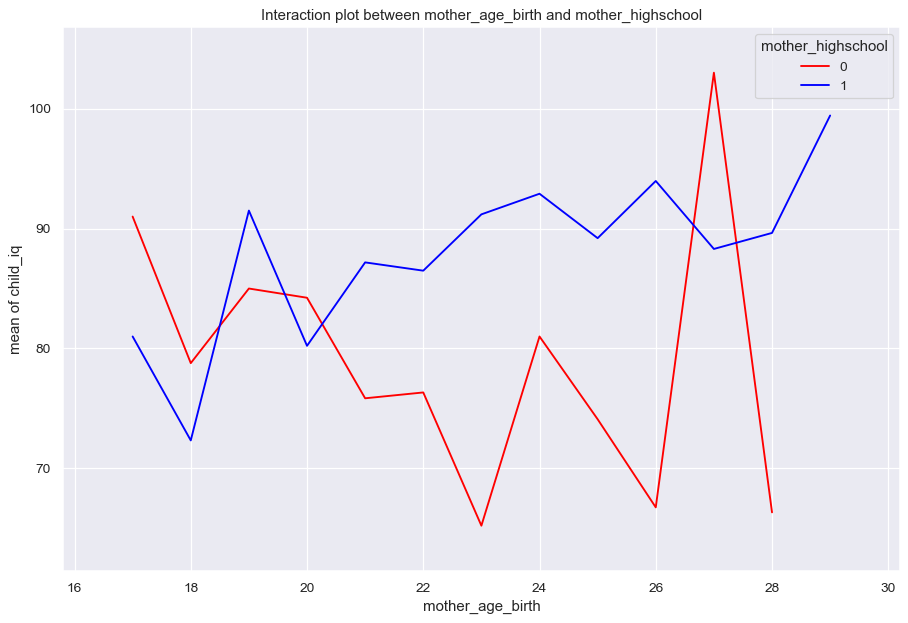

In [25]:
from statsmodels.graphics.factorplots import interaction_plot
with plt.rc_context():
    plt.rc("figure", figsize=(12,8), dpi=90)
    interaction_plot(
        x=df['mother_age_birth'],
        trace=df['mother_highschool'],
        response=df['child_iq'],
        colors=["red", "blue"],
        markers=[" ", " "],
        ms=10
    )

plt.title('Interaction plot between mother_age_birth and mother_highschool')
plt.show()

In [26]:
from math import exp

df_2 = df.copy()
df_2['mother_age * mother_highschool'] = df_2.apply(lambda row: row['mother_age_birth'] *  row['mother_highschool'], axis=1)

X2 = sm.add_constant(df_2.drop(['child_iq'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     17.98
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           5.97e-21
Time:                        19:17:52   Log-Likelihood:                -1868.1
No. Observations:                 434   AIC:                             3752.
Df Residuals:                     426   BIC:                             3785.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Both R2 and Adjusted-R2 are better than the 1st multi-linear regression from before. mother_highschool is not significant at the 10% level anymore, but the new interaction term is. It is equal to 1.53, and coefficient of mother_age_birth is -0.96 (p-val=0.16) which mean that for mothers that completed highschool, giving birth one year later raise on average Child's IQ by approx. 1.53 - 0.96 = 0.57 IQ point.

---

**We now take a step-back from the above results, and get back to our previous best regression from last section (with 3 regressors); we include interaction terms between these 3 regressors, and here is what we obtain:**

In [27]:
import statsmodels.api as sm
from scipy import stats

df_2 = df.copy()
df_2['mother_iq * mother_highschool'] = df_2.apply(lambda row: row['mother_highschool'] *  row['mother_iq'], axis=1)
df_2['mother_work_3 * mother_highschool'] = df_2.apply(lambda row: row['mother_highschool'] *  row['mother_work_3'], axis=1)
df_2['mother_iq * mother_work_3'] = df_2.apply(lambda row: row['mother_iq'] *  row['mother_work_3'], axis=1)

X2 = sm.add_constant(df_2.drop(['child_iq', 'mother_work_2', 'mother_work_4', 'mother_age_birth'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     21.85
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.95e-22
Time:                        19:17:52   Log-Likelihood:                -1866.2
No. Observations:                 434   AIC:                             3746.
Df Residuals:                     427   BIC:                             3775.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


All scores have gone up, but only the interaction between mother_iq and mother_highschool is significant at the 10% level. Let's remove the other interactions.

In [28]:
import statsmodels.api as sm
from scipy import stats

df_2 = df.copy()
df_2['mother_iq * mother_highschool'] = df_2.apply(lambda row: row['mother_highschool'] *  row['mother_iq'], axis=1)

X2 = sm.add_constant(df_2.drop(['child_iq', 'mother_work_2', 'mother_work_4', 'mother_age_birth'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     32.91
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.05e-24
Time:                        19:17:52   Log-Likelihood:                -1866.2
No. Observations:                 434   AIC:                             3742.
Df Residuals:                     429   BIC:                             3763.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Adj-R2, AIC and BIC are indeed better. We can see that for mothers that completed highschool, one extra IQ point means that the Child will have 0.96-0.49 = 0.47 more IQ point on average. For mothers that did not complete highschool, children have on average 50 less IQ point, but one extra IQ point for the mother is 0.95 extra for the child.

It means that starting from mothers with ~100 IQ points, i.e. children with ~90IQ points for both highschool graduates and non-highschool graduates, the marginal gains for one extra IQ point are greater for mothers without highschool diploma.

---
**Final model:** Now, if we add mother_age * mother_highschool to the previous regression, we get:

In [29]:
import statsmodels.api as sm

df_2 = df.copy()
df_2['mother_iq * mother_highschool'] = df_2.apply(lambda row: row['mother_highschool'] *  row['mother_iq'], axis=1)

df_2['mother_age * mother_highschool'] = df_2.apply(lambda row: row['mother_age_birth'] *  row['mother_highschool'], axis=1)


X2 = sm.add_constant(df_2.drop(['child_iq', 'mother_work_2', 'mother_work_4', 'mother_age_birth'], axis=1))
est = sm.OLS(df['child_iq'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     26.90
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.14e-23
Time:                        19:17:52   Log-Likelihood:                -1865.0
No. Observations:                 434   AIC:                             3742.
Df Residuals:                     428   BIC:                             3766.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

c:\Users\wawa_\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


This will be our last model, with R2 = 0.239 and Adj-R2 = 0.230 (slightly better than before).

# Conclusion

**Our best model is obtained on the following predictors: mother_highschool, mother_iq, mother_work_3 (if mother worked part-time during first year after birth) and with the following interaction terms: mother_iq * mother_highschool and mother_age * mother_highschool.** 

**We observed that the higher the mother's IQ the higher the child's IQ, and same goes if the mother went to high school or worked part-time during first year after birth compared to other alternatives. Mother's IQ has an higher impact for mothers that did not graduate high school, and mother's age at the time of birth has a positive impact for mothers that graduated highschool.**

>**Our best model single predictor model performed 0.201 R2, our best multilinear model performed 0.219 R2 and 0.213 Adj-R2, and our best multilinear model with interaction terms performed *0.239 R2 and 0.230 Adj-R2*; these are satisfying figures yet pretty far from 1. This is the sign that our model is unable to capture a lot of the variation in the target variable, and that the feature capturing most of the variation of child_iq is mother_iq.** 